In [1]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

%load_ext autoreload

Load forcing.


In [2]:
time_start, time_end = "1998-01-01", "2022-01-01"

data = xr.open_dataset("../1_data_processing/1_1_Forcing/products/all_stations_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("../1_data_processing/1_1_Forcing/products/all_stations_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

In [3]:
data

<xarray.Dataset> Size: 13MB
Dimensions:              (latitude: 3, longitude: 3, time: 8767, depth: 3)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float64 24B 22.75 31.6 50.0
  * longitude            (longitude) float64 24B -158.0 -150.0 -64.2
  * time                 (time) datetime64[ns] 70kB 1998-01-01 ... 2022-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 2MB 23.52...
    U                    (latitude, longitude, time, depth) float64 2MB 0.016...
    V                    (latitude, longitude, time, depth) float64 2MB -0.07...
    mnkc_epi             (latitude, longitude, time) float64 631kB 0.269 ... nan
    mnkc_hmlmeso         (latitude, longitude, time) float64 631kB 0.7915 ......
    mnkc_lmeso           (latitude, longitude, time) float64 631kB 2.173 ... nan
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 631kB 0.4889 ......
    mnkc_umeso           (latitude, longitude, time) float64 631kB 0.4931 ......
    npp                  (latitude, longitude, time) float64 631kB 315.7 ... nan
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 2MB 117.3...
    zeu                  (latitude, longitude, time) float64 631kB 78.19 ... nan
    zooc                 (latitude, longitude, time) float64 631kB 0.2896 ......

In [4]:
cafe_npp

<xarray.Dataset> Size: 701kB
Dimensions:    (time: 8767, latitude: 3, longitude: 3)
Coordinates:
  * latitude   (latitude) float64 24B 22.75 31.6 50.0
  * longitude  (longitude) float64 24B -158.0 -150.0 -64.2
  * time       (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2022-01-01
Data variables:
    CAFE       (time, latitude, longitude) float64 631kB 306.4 nan ... nan nan
Attributes:
    Conventions:  CF-1.8
    History:      2023-01-02 08:55:09.514113 Python
    Keywords:     Primary Production
    PI Contact:   tryankeogh@csir.co.za
    PI Name:      Thomas Ryan-Keogh

Load observations.

First I multiply the observations by the average epipelagic layer depth (150m) to have a biomass in m2 rather than m3.


In [5]:
def update_layer(data: xr.DataArray, epipelagic_size):
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = 150 * pint.application_registry("meter")

obs_bats = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Bats_obs.zarr", engine="zarr")
obs_bats = update_layer(obs_bats, epipelagic_size)
obs_bats = Observation(obs_bats)

obs_hot = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Hot_obs.zarr", engine="zarr")
obs_hot = update_layer(obs_hot, epipelagic_size)
obs_hot = Observation(obs_hot)

obs_papa = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Papa_obs.zarr", engine="zarr")
obs_papa = update_layer(obs_papa, epipelagic_size)
obs_papa = Observation(obs_papa)

observations = [obs_bats, obs_hot, obs_papa]

Create structure for SeapoPym simulation.


In [6]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2024-12-02 16:35:03,237 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



Setup the cost function.


In [7]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 1),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 100),
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 1),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 100),
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
    ),
]

In [8]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [9]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.6,
    NGEN=3,
    POP_SIZE=10,
    cost_function_weight=(-(1 / 3), -(1 / 3), -(1 / 3)),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [10]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [11]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    # client=client,
)

And watch the magic on the Dask dashboard :


In [12]:
genetic_algo.client

And execute the process.


In [13]:
viewer = genetic_algo.optimize()

2024-12-02 16:35:04,158 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-02 16:35:04,160 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-02 16:35:04,171 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-12-02 16:35:04,246 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-12-02 16:35:04,273 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-12-02 16:35:04,280 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-12-02 16:35:04,282 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-12-02 16:35:04,293 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-12-02 16:35:04,315 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-12-02 16:35:04,325 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

Finaly here is the result :


In [14]:
viewer.stats

,mean,std,min,max,valid
generation,,,,,
0,1.488554,2.322578e+00,0.268756,5.627350,5
1,0.986130,1.640707e+00,0.306169,5.627350,10
2,2.556539,6.978345e+00,0.306169,22.416668,10
3,0.306169,1.370647e-09,0.306169,0.306169,10


In [15]:
viewer.logbook

D1N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                     19.553000   
                               1                     69.498290   
                               2                     29.158665   
                               3                     22.992224   
                               4                     53.248488   
                               5                     77.258086   
                               6                      9.391236   
                               7                     25.351818   
                               8                     39.464046   
                               9                     96.068159   
1          False               2                     19.553000   
                               3                     29.158665   
                               4                     19.553000   
                               5                     29.158665   
                               8                     25.351818   
                               9                     19.553000   
           True                0                     69.498290   
                               1                     19.553000   
                               6                     96.068159   
                               7                     96.068159   
2          False               2                     29.158665   
                               3                     19.553000   
                               4                     19.553000   
                               5                     29.158665   
                               8                     25.351818   
                               9                     96.068159   
           True                0                     29.158665   
                               1                     29.158665   
                               6                     29.158665   
                               7                     19.553000   
3          False               2                     29.158665   
                               3                     29.158665   
                               4                     19.553000   
                               5                     29.158665   
                               6                     29.158665   
                               7                     29.158665   
           True                0                     29.158665   
                               1                     19.553000   
                               8                     29.158665   
                               9                     29.158665   

                                           D1N1_inv_lambda_rate  \
generation previous_generation individual                         
0          False               0                       0.323715   
                               1                       0.336314   
                               2                       0.352710   
                               3                       0.290549   
                               4                       0.887196   
                               5                       0.692893   
                               6                       0.606728   
                               7                       0.547331   
                               8                       0.919964   
                               9                       0.054006   
1          False               2                       0.352710   
                               3                       0.323715   
                               4                       0.352710   
                               5                       0.323715   
                               8                       0.547331   
                               9                       0.323715   
           True                0                       0.336314 

In [16]:
viewer.hall_of_fame

D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
0          7                     25.351818              0.547331   
3          7                     29.158665              0.323715   
           5                     29.158665              0.323715   
           3                     29.158665              0.323715   
1          3                     29.158665              0.323715   
3          2                     29.158665              0.323715   
           6                     29.158665              0.323715   
2          5                     29.158665              0.323715   
3          4                     19.553000              0.323715   
2          3                     19.553000              0.323715   
1          8                     25.351818              0.547331   
           5                     29.158665              0.323715   
0          2                     29.158665              0.352710   
2          8                     25.351818              0.547331   
           2                     29.158665              0.323715   
0          0                     19.553000              0.323715   
1          4                     19.553000              0.352710   
2          4                     19.553000              0.352710   
1          9                     19.553000              0.323715   
           2                     19.553000              0.352710   
0          9                     96.068159              0.054006   
           1                     69.498290              0.336314   
2          9                     96.068159              0.054006   

                       D1N1_energy_coefficient  D2N1_inv_lambda_max  \
generation individual                                                 
0          7                          0.302557            65.332991   
3          7                          0.435501            43.525423   
           5                          0.435501            43.525423   
           3                          0.435501            43.525423   
1          3                          0.435501            43.525423   
3          2                          0.435501            43.525423   
           6                          0.435501            43.525423   
2          5                          0.435501            43.525423   
3          4                          0.435501            43.525423   
2          3                          0.435501            43.525423   
1          8                          0.435501            43.525423   
           5                          0.280424            49.072671   
0          2                          0.280424            49.072671   
2          8                          0.111657            70.304375   
           2                          0.435501            43.525423   
0          0                          0.435501            43.525423   
1          4                          0.435501            43.525423   
2          4                          0.435501            43.525423   
1          9                          0.302557            65.332991   
           2                          0.280424            49.072671   
0          9                          0.111657            70.304375   
           1                          0.238411            73.893389   
2          9                          0.435501            43.525423   

                       D2N1_inv_lambda_rate  D2N1_energy_coefficient  \
generation individual                                                  
0          7                       0.190455                 0.455694   
3          7                       0.201024                 0.345062   
           5                       0.201024                 0.345062   
           3                       0.201024                 0.345062   
1          3                       0.201024                 0.345062   
3          2                       0.20102

In [17]:
viewer.fitness_evolution()

In [18]:
viewer.box_plot(3)

In [19]:
fig = viewer.parallel_coordinates(
    1000,
    colorscale=[
        [0, "rgba(220, 80, 80, 0.8)"],
        [0.5, "rgba(255,200,0,0.5)"],
        [1, "rgba(255,200,150,0.0)"],
    ],
)
fig.update_layout(width=1000, height=700)

In [20]:
from seapopym_optimization import wrapper

model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        [
            [10.38, -0.11, 72, 0.09, 1, 1, 0.1],
            [10.38, -0.11, 44, 0.18, 2, 1, 0.46],
        ],
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

2024-12-02 16:35:16,727 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-02 16:35:16,731 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-02 16:35:16,738 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-12-02 16:35:16,776 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-12-02 16:35:16,802 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-12-02 16:35:16,809 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-12-02 16:35:16,811 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-12-02 16:35:16,822 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-12-02 16:35:16,844 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-12-02 16:35:16,854 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:341: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



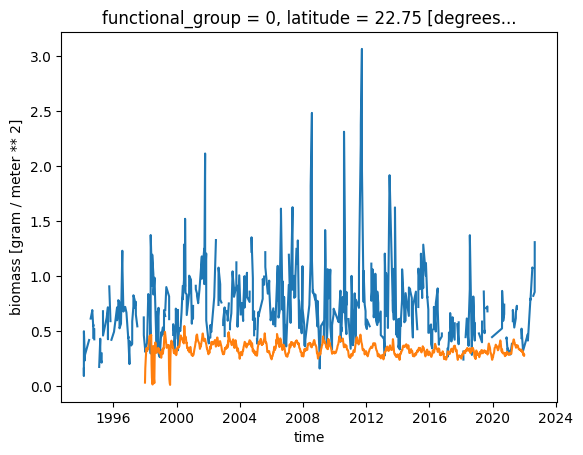

In [21]:
obs_hot.observation.day.pint.quantify().pint.to("g/m2").plot()
biomass_print.sel(latitude=22.75, longitude=-158, functional_group=0).pint.quantify().pint.to("g/m2").plot()